# Applying SHRED to the Mice Dataset 

Dataset obtained from Allen Brain Atlas https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

Goal: Reconstruct LFP potential from unit firing rate recording

Spike band: 
- ~30 kHz sample rate
- 500 Hz analog hi-pass
- 150 Hz digital hi-pass


LFP band: 
- ~2.5 kHz original sample rate
- 1000 Hz analog lo-pass
- 625 Hz digital lo-pass
- NWB includes every 2nd sample and every 4th channel

In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge
from scipy.ndimage import gaussian_filter1d


In [2]:
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

In [3]:
#Set up data cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
HOME_DIR = "/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED"
data_directory = os.path.join(HOME_DIR, "mice/data") #where data will be stored
manifest_path = os.path.join(data_directory, 'manifest.json')
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)

/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()


# Can also filter which mice to select
filtered_sessions = sessions[(sessions.index == 756029989)]

filtered_sessions.head()

Total number of sessions: 58


/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:741: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: pd.DataFrame(grp)[field_key].unique())
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:743: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array(['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT',
        'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam'], dtype=object)
 array(['TH',

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


In [5]:
#Loading dataset for specific session
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])


/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:741: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: pd.DataFrame(grp)[field_key].unique())
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:743: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array(['APN', 'LP', 'MB', 'DG', 'CA1', 'VISam', nan], dtype=object)
 array(['TH', 'Eth', 'APN', 'POL', 'LP', 'DG', 'CA1', 'VISpm', nan],
       dtype=object)


['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_c

**Finding well-isolated, high-firing rate unit from the visual cortex and the associated LFP**

In [6]:
probe_id = session.probes.index.values[0]

units_of_interest = session.units[(session.units.probe_id == probe_id) &
                                  (session.units.ecephys_structure_acronym.str.find('VIS') > -1) &
                                  (session.units.firing_rate > 10) & 
                                  (session.units.nn_hit_rate > 0.95)]
                                  
len(units_of_interest)

/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


20

In [7]:
unit_id = units_of_interest.index.values[0]

channel_index = units_of_interest.loc[unit_id].probe_channel_number
print(unit_id)
print(channel_index)

951816951
211


In [8]:
channel_id = session.channels[(session.channels.probe_channel_number == channel_index) & 
                                     (session.channels.probe_id == probe_id)].index.values[0]
channel_id

850126796

In [9]:
# list the probes recorded from in this session
session.probes.head()

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
760640083,probeA,See electrode locations,29999.949611,1249.997900,True
760640087,probeB,See electrode locations,29999.902541,1249.995939,True
760640090,probeC,See electrode locations,29999.905275,1249.996053,True
760640094,probeD,See electrode locations,29999.905275,1249.996053,True
760640097,probeE,See electrode locations,29999.985335,1249.999389,True


In [10]:
{session.probes.loc[probe_id].description : 
     list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
     for probe_id in session.probes.index.values}

{'probeA': [nan, 'APN', 'DG', 'CA1', 'VISam'],
 'probeB': ['VISpm', nan, 'LP', 'DG', 'CA1', 'PO', 'Eth'],
 'probeC': ['VISp', nan, 'POL', 'APN', 'MB', 'SCig', 'POST', 'SUB'],
 'probeD': ['VISl', nan, 'TH', 'DG', 'CA3', 'CA1'],
 'probeE': [nan, 'VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal'],
 'probeF': [nan, 'DG', 'CA1', 'VISrl']}

In [11]:
lfp = session.get_lfp(probe_id)

/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
Downloading: 100%|██████████| 2.27G/2.27G [04:14<00:00, 8.90MB/s]
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this w

In [12]:
start_time = 1585.734418
end_time = 1587.736098

spike_times = session.spike_times[unit_id]

times_in_range = spike_times[(spike_times > start_time) & (spike_times < end_time)]

lfp_data = lfp.sel(time = slice(start_time, end_time))
lfp_data = lfp_data.sel(channel = channel_id, method='nearest')

/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro311/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Text(0, 0.5, 'LFP (V)')

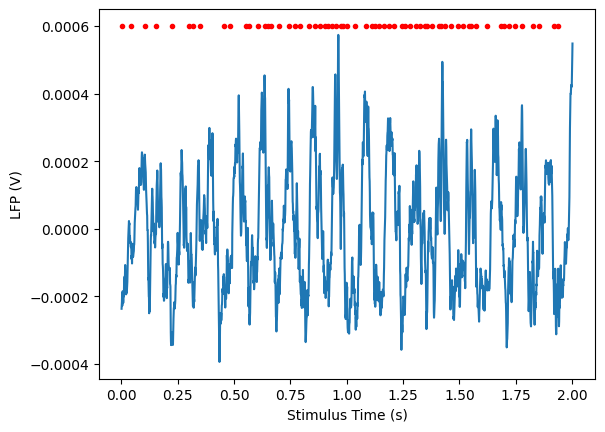

In [13]:
plt.plot(lfp_data.time - np.ones(lfp_data.time.shape)*1585.734418, lfp_data)
plt.plot(times_in_range- np.ones(times_in_range.shape)*1585.734418, np.ones(times_in_range.shape)*6e-4, '.r')
plt.xlabel('Stimulus Time (s)')
plt.ylabel('LFP (V)')


Text(0, 0.5, 'LFP (V)')

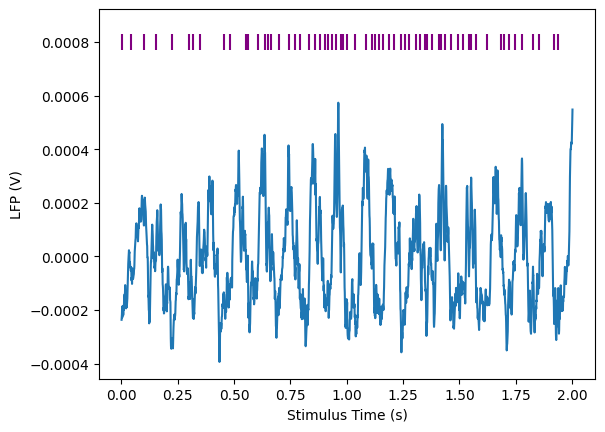

In [14]:
### Converting to numpy arrays
time = lfp_data.time.values - np.ones(lfp_data.time.shape)*1585.734418
lfp_array = lfp_data.values

target_arr = np.round(lfp_data.time, decimals = 3)
query_vals = np.round(times_in_range, decimals = 3)

indices = [np.where(target_arr == val)[0][0] for val in query_vals]
unit_array = np.zeros((lfp_array.shape))
unit_array[indices] = 1

ones_indices = np.where(unit_array == 1)[0]
plt.eventplot(time[ones_indices], lineoffsets=0.0008, linelengths=0.00006, color = 'purple')  # spike train style
plt.plot(time , lfp_array)

# plt.plot(time, unit_array*0.0004, '.r')
plt.xlabel('Stimulus Time (s)')
plt.ylabel('LFP (V)')



In [15]:
sampling_rate = unit_array.shape[0]/(1587.736098 - 1585.734418)  # Hz
print(sampling_rate)
sigma_ms = 20         # smoothing in milliseconds
sigma_samples = sigma_ms / 1000 * sampling_rate  # convert to samples

firing_rate = gaussian_filter1d(unit_array, sigma=sigma_samples) * sampling_rate

1249.9500419647006


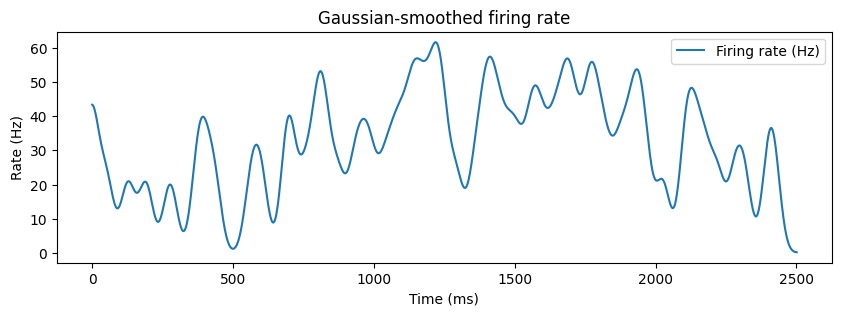

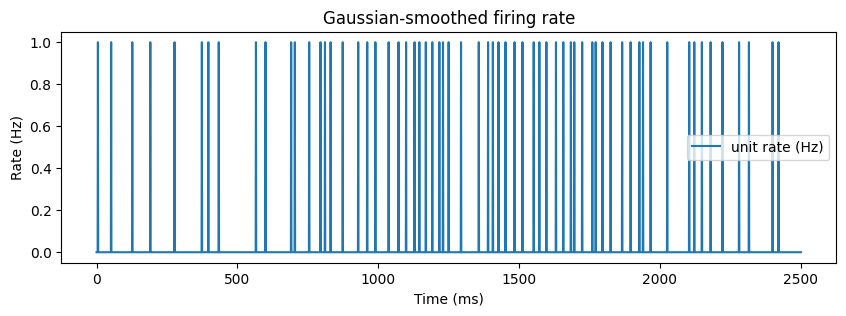

In [16]:
plt.figure(figsize=(10, 3))
plt.plot(firing_rate, label='Firing rate (Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Rate (Hz)')
plt.title('Gaussian-smoothed firing rate')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(unit_array, label='unit rate (Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Rate (Hz)')
plt.title('Gaussian-smoothed firing rate')
plt.legend()
plt.show()


Applying SHRED on dataset

In [18]:
#Importing packages

os.environ["CUDA_VISIBLE_DEVICES"]="0"
SHRED_DIR = os.path.join(HOME_DIR, "sindy-shred-main")
import sys 
sys.path.append(SHRED_DIR)

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import sindy_shred


os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [20]:
load_X = np.vstack((lfp_array, firing_rate)).T
print(load_X.shape)

n_t = load_X.shape[0]
n_s = load_X.shape[1]
probe = 'a'
dt = time[1] - time[0]
sr = time.shape[0]/2
print(sr)
print(dt)


latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

num_neurons = 1 
lags = 100
test_val_size = int(n_t*0.2)
print(test_val_size)
train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[int(test_val_size/2):test_val_size]
test_indices = valid_test_indices[:int(test_val_size/2)]

(2502, 2)
1251.0
0.0008000013435776054
500


In [29]:
k = 2
neuron_locations = [1] #input = firing rate
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)
### Generate input sequences to a SHRED model
all_data_in = np.zeros((n_t - lags, lags, num_neurons))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                library_dim=library_dim, poly_order=poly_order,
                                include_sine=include_sine, dt=dt, layer_norm=False, sindy = False).to(device)

validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                    lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=0.0,
                                    optimizer="AdamW", thres_epoch=100)

test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
mse_test = np.linalg.norm(test_recons[:,0] - test_ground_truth[:,0]) / np.linalg.norm(test_ground_truth[:,0])
print('mse test', mse_test)
train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
mse_train = np.linalg.norm(train_recons[:,0] - train_ground_truth[:,0]) / np.linalg.norm(train_ground_truth[:,0])
print('mse train', mse_train)


file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/train_recons_{k}.npy")
np.save(file_path, train_recons)
file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/test_recons_{k}.npy")
np.save(file_path, test_recons)
file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/train_gt_{k}.npy")
np.save(file_path, train_ground_truth)
file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/test_gt_{k}.npy")
np.save(file_path, test_ground_truth)
file_path = os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/mse_{k}.npy")
np.save(file_path, [mse_train, mse_test])

1 : tensor(0.0298, grad_fn=<AddBackward0>)
2 : tensor(0.0310, grad_fn=<AddBackward0>)
3 : tensor(0.0192, grad_fn=<AddBackward0>)
4 : tensor(0.0089, grad_fn=<AddBackward0>)
5 : tensor(0.0146, grad_fn=<AddBackward0>)
6 : tensor(0.0113, grad_fn=<AddBackward0>)
7 : tensor(0.0122, grad_fn=<AddBackward0>)
8 : tensor(0.0130, grad_fn=<AddBackward0>)
9 : tensor(0.0110, grad_fn=<AddBackward0>)
10 : tensor(0.0128, grad_fn=<AddBackward0>)
11 : tensor(0.0122, grad_fn=<AddBackward0>)
12 : tensor(0.0140, grad_fn=<AddBackward0>)
13 : tensor(0.0133, grad_fn=<AddBackward0>)
14 : tensor(0.0125, grad_fn=<AddBackward0>)
15 : tensor(0.0127, grad_fn=<AddBackward0>)
16 : tensor(0.0130, grad_fn=<AddBackward0>)
17 : tensor(0.0130, grad_fn=<AddBackward0>)
18 : tensor(0.0147, grad_fn=<AddBackward0>)
19 : tensor(0.0185, grad_fn=<AddBackward0>)
20 : tensor(0.0168, grad_fn=<AddBackward0>)
21 : tensor(0.0155, grad_fn=<AddBackward0>)
22 : tensor(0.0129, grad_fn=<AddBackward0>)
23 : tensor(0.0123, grad_fn=<AddBackward0

In [36]:
trial = 2

train_recons = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/train_recons_{trial}.npy"))
test_recons = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/test_recons_{trial}.npy"))
train_gt = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/train_gt_{trial}.npy"))
test_gt = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/test_gt_{trial}.npy"))
mse = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/mse_{trial}.npy"))
print(mse)

recons = np.vstack((train_recons, test_recons))
gt = np.vstack((train_gt, test_gt))

mse_train = np.linalg.norm(train_recons[:,1] - train_ground_truth[:,1]) / np.linalg.norm(train_ground_truth[:,1])

mse_test = np.linalg.norm(test_recons[:,1] - test_ground_truth[:,1]) / np.linalg.norm(test_ground_truth[:,1])
print(mse_train, mse_test)

[0.6583016 1.0700511]
0.059737723 0.06126062


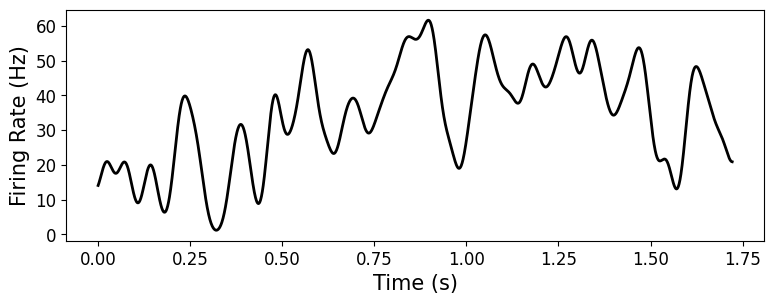

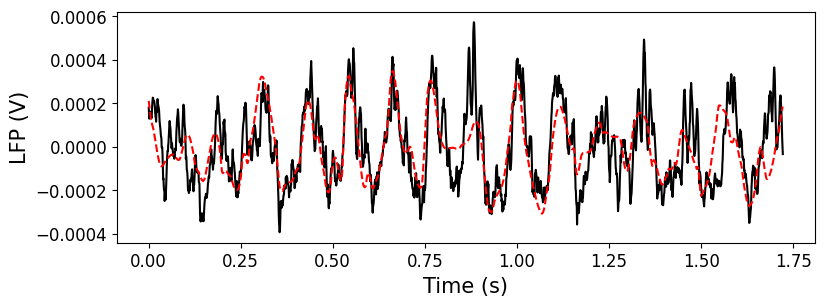

In [35]:
plt.figure(figsize = (9,3))
plt.plot(time[:recons[:,1].shape[0]], gt[:,1], color = 'black', label = 'Ground Truth', linewidth = 2)
# plt.plot(time[:recons[:,1].shape[0]], recons[:,1], color = 'red', linestyle = '--', label = 'Reconstruction')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Firing Rate (Hz)', fontsize = 15)
# plt.legend(fontsize = 13, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, "mice/data_output/figs/unitlfp_fr.png"), transparent=True, dpi=500)
plt.show()

plt.figure(figsize = (9,3))
plt.plot(time[:recons[:,1].shape[0]], gt[:,0], color = 'black', label = 'Ground Truth')
plt.plot(time[:recons[:,1].shape[0]], recons[:,0], color = 'red', linestyle = '--', label = 'Reconstruction')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('LFP (V)', fontsize = 15)
# plt.legend(fontsize = 13, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, "mice/data_output/figs/unitlfp_lfp.png"), transparent=True, dpi=500)
plt.show()

test out shape (250, 2)
data out shape (2152, 2)


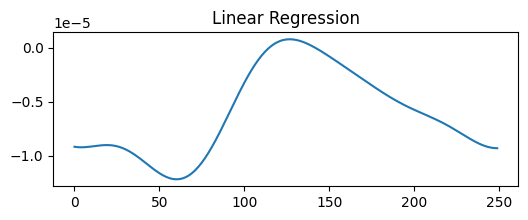

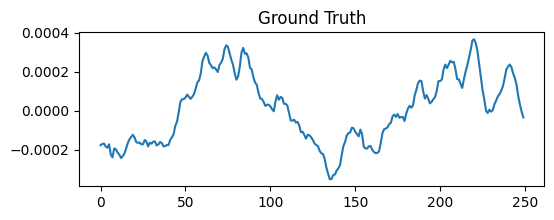

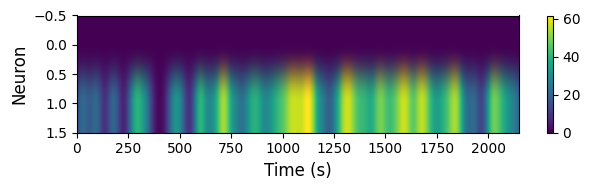

out shape (2152, 2)


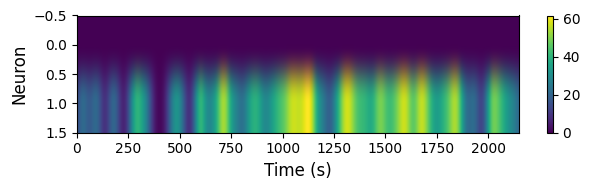

mse train, test [0.9992373, 1.0118736]
mse whole 1.000669
4.0941538e-07


In [46]:
##### Linear Regression

from sklearn.linear_model import LinearRegression
#### Linear Regression
## Drifting Gratings

trial = 2
train_recon = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/train_recons_{trial}.npy"))
test_recon = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/test_recons_{trial}.npy"))
data_recon = np.vstack((train_recon, test_recon))

train_gt = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/train_gt_{trial}.npy"))
test_gt = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/test_gt_{trial}.npy"))
data_gt= np.vstack((train_gt, test_gt))

neuron_loc = 1
mse = np.load(os.path.join(HOME_DIR, f"mice/data_output/exp_Biii/mse_{trial}.npy"))


##### Linear Regression

from sklearn.linear_model import LinearRegression



train_in = train_gt[:, neuron_loc].reshape(-1,1)
test_in = test_gt[:, neuron_loc].reshape(-1,1)
data_in = data_gt[:, neuron_loc].reshape(-1,1)
train_out = train_gt



model = LinearRegression()
model.fit(train_in, train_out)

test_out = model.predict(test_in)
print('test out shape',test_out.shape)
data_out = model.predict(data_in)
print('data out shape',data_out.shape)
plt.figure(figsize = (6,2))
plt.plot(test_out[:,0])
plt.title('Linear Regression')
plt.show()

plt.figure(figsize = (6,2))
plt.plot(test_gt[:,0])
plt.title('Ground Truth')
plt.show()

######### Plotting the reconstruction
fig, ax = plt.subplots(figsize = (6.5,2))
plt.imshow(data_gt.T, aspect = "auto")
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize =12)


plt.colorbar()
plt.tight_layout()
# plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/{name}_recon.png'), transparent = True, dpi = 400)

plt.show()

print('out shape',data_out.shape)
fig, ax = plt.subplots(figsize = (6.5,2))
plt.imshow(data_out.T, aspect = "auto")
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize = 12)
plt.colorbar()

plt.tight_layout()
# plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/{name}_linear.png'), transparent = True, dpi = 400)
plt.show()

n_train = train_out.shape[0]
mask = np.ones(train_out.shape[1], dtype=bool)
mask[neuron_loc] = False
train_ex = data_out[:n_train,:].T[mask]
train_gt_ex = train_gt.T[mask]
mask = np.ones(test_out.shape[1], dtype=bool)
mask[neuron_loc] = False
test_ex = test_out.T[mask]
test_gt_ex = test_gt.T[mask]
mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)
print('mse train, test', [mse_train, mse_test])


mask = np.ones(train_out.shape[1], dtype=bool)
mask[neuron_loc] = False
data_ex = data_out.T[mask]
data_gt_ex = data_gt.T[mask]
mse_whole = np.linalg.norm(data_ex - data_gt_ex) / np.linalg.norm(data_gt_ex)
print('mse whole', mse_whole)


mse = np.linalg.norm(data_out[:,1] - data_gt[:,1]) / np.linalg.norm(data_gt[:,1])
print(mse)
